In [88]:
import copy
import time

import torch
import numpy as np
from sklearn.model_selection import train_test_split

from cuticulus.datasets import RoughSmoothFull

In [89]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [90]:
class TorchDS(torch.utils.data.Dataset):
    """Torch dataset class for ant image dataset."""

    def __init__(self, imgs: np.ndarray, labels: np.ndarray):
        """Initialize dataset.

        Args:
            imgs (np.ndarray): List of data.
            labels (np.ndarray): List of labels.
        """
        self.imgs = imgs
        self.labels = labels

    def __len__(self) -> int:
        """Return length of dataset.

        Returns:
            int: Length of dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx) -> tuple:
        """Return item at index idx.

        Returns:
            tuple: Tuple of image and label.
        """
        return self.imgs[idx], self.labels[idx]

In [91]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {
        'train_loss': [],
        'train_acc': [], 
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            elif phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [92]:
torch.cuda.is_available()

True

In [93]:
ds = RoughSmoothFull((256, 256))

[08:52:59] Loaded labels.                                                       ]8;id=705564;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=36694;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#89\89]8;;\

           Loaded dataset.                                                     ]8;id=63963;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=216193;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#114\114]8;;\

           Unique images considered: 2499                                      ]8;id=500339;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=687379;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#135\135]8;;\

           Samples per class:                                                  ]8;id=582965;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=584429;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 1072                                                             ]8;id=594544;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=340214;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 1427                                                             ]8;id=178317;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=320679;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

In [94]:
images, labels = ds.images, ds.labels

# torch expects images to be in format (batch, channels, height, width)
images = images.transpose(0, 3, 1, 2)
print(images.shape, labels.shape)

# convert to float
images = images.astype(np.float32)
print(images.dtype, labels.dtype)

# split into train, test, and validation
val_size = 0.1
test_size = 0.1 / (1 - val_size)

train_images, val_images, train_labels, val_labels = train_test_split(
    images,
    labels,
    test_size=val_size,
    random_state=42,
)
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images,
    train_labels,
    test_size=test_size,
    random_state=42,
)


(2499, 3, 256, 256) (2499,)
float32 int64


In [95]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.eval()

Using cache found in /home/ngardn10/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [97]:
train_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(train_images, train_labels),
    batch_size=16,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(val_images, val_labels),
    batch_size=16,
    shuffle=True
)
criterion = torch.nn.CrossEntropyLoss()
model, hist = train_model(
    model,
    dataloaders={
        "train": train_loader,
        "val": val_loader
    },
    criterion=criterion,
    optimizer=optimizer_ft,
    num_epochs=20,
)

Epoch 0/19
----------
train Loss: 0.4546 Acc: 0.7874
val Loss: 0.3447 Acc: 0.8440

Epoch 1/19
----------
train Loss: 0.2749 Acc: 0.8884
val Loss: 0.3283 Acc: 0.8360

Epoch 2/19
----------
train Loss: 0.1522 Acc: 0.9385
val Loss: 0.3942 Acc: 0.8400

Epoch 3/19
----------
train Loss: 0.0877 Acc: 0.9745
val Loss: 0.4364 Acc: 0.8440

Epoch 4/19
----------
train Loss: 0.0520 Acc: 0.9860
val Loss: 0.5004 Acc: 0.8400

Epoch 5/19
----------
train Loss: 0.0328 Acc: 0.9900
val Loss: 0.5603 Acc: 0.8400

Epoch 6/19
----------
train Loss: 0.0306 Acc: 0.9930
val Loss: 0.6130 Acc: 0.8480

Epoch 7/19
----------
train Loss: 0.0189 Acc: 0.9955
val Loss: 0.5483 Acc: 0.8440

Epoch 8/19
----------
train Loss: 0.0145 Acc: 0.9970
val Loss: 0.5640 Acc: 0.8480

Epoch 9/19
----------
train Loss: 0.0188 Acc: 0.9955
val Loss: 0.6005 Acc: 0.8360

Epoch 10/19
----------
train Loss: 0.0241 Acc: 0.9910
val Loss: 0.6142 Acc: 0.8560

Epoch 11/19
----------
train Loss: 0.0160 Acc: 0.9965
val Loss: 0.6259 Acc: 0.8240

Ep

In [98]:
train_acc = [hist['train_acc'][i].cpu().numpy() for i in range(len(hist['train_acc']))]
train_loss = hist['train_loss']

val_acc = [hist['val_acc'][i].cpu().numpy() for i in range(len(hist['val_acc']))]
val_loss = hist['val_loss']

In [99]:
train_acc

[array(0.7873937),
 array(0.88844422),
 array(0.93846923),
 array(0.97448724),
 array(0.985993),
 array(0.989995),
 array(0.9929965),
 array(0.99549775),
 array(0.9969985),
 array(0.99549775),
 array(0.9909955),
 array(0.99649825),
 array(0.9969985),
 array(0.9949975),
 array(0.99549775),
 array(0.993997),
 array(0.98849425),
 array(0.99149575),
 array(0.9949975),
 array(0.99649825)]

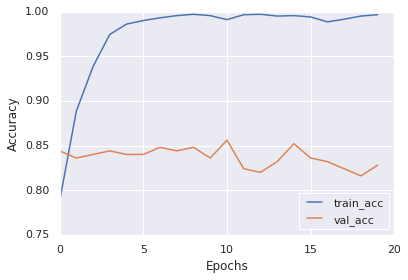

In [104]:
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

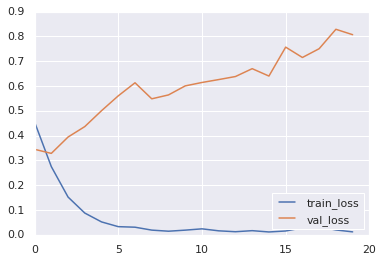

In [101]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='lower right')